# EDA | Problem exploration
---
---

# Imports

#### Standard library imports

In [127]:
import sys
sys.path.append("../../")
import pickle

#### Third party imports

In [128]:
import pandas as pd
pd.set_option('display.max_columns', 50)
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#### Local application imports

In [129]:
%load_ext autoreload
%autoreload 2

from pkg_dir.config import *
from pkg_dir.src.utils import *
from pkg_dir.src.functions import *
from pkg_dir.src.parameters import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Extracting data

## 2022-2023 Dataset

In [ ]:
## Params
path = '../../pkg_dir/data/pickles/robs'
name = 'dataset.pkl'


## Reading extract object saved as pickle locally
pkl_obj = path + "/" + name

with open(pkl_obj, 'rb') as obj_content:
    dfx = pickle.load(obj_content)

In [ ]:
dfx

## Query

In [ ]:
## Function parameters
db_crds = 'pc_db_prod'
sql_files_path = '../../pkg_dir/sql/'
sql_script = 'appointments.sql'
sql_params = sql_params_appointments

In [ ]:
dfx = sql_to_df(db_crds, sql_files_path, sql_script, sql_params)

In [ ]:
## Reference to simplify labels in appointment status
values_map = {
    
    'COMPLETADA': 'completed',
    'SALA_ESPERA': 'completed',
    'CONSULTA': 'completed',
    'CONFIRMADO_PAGO': 'completed',

    'NO_PRESENTO': 'no_show',
    'MENSAJE_DEJADO': 'no_show',
    'NO_CONFIRMADO': 'no_show',
    'CONFIRMADO': 'no_show',
    'LLEGA_TARDE_ESPERA': 'no_show',
    'REAGENDAR': 'no_show',
    
}

In [ ]:
## Mapping values according to reference
dfx['appointment_status_simple'] = dfx['appointment_status'].map(values_map).fillna(dfx['appointment_status'])

In [ ]:
## Formatting appointment date
dfx['appointment_date'] = pd.to_datetime(dfx['appointment_date'])

# Solving questions - no shows

---
### What was the no-show rate in 2023?

##### 
##### Using query

In [ ]:
sql_string = """
SELECT cita.citaid as appointment_id

FROM cita

WHERE citafecha >= '2000-11-03'
  AND citafecha <= '2021-01-01'

ORDER BY
    citafecha DESC

LIMIT 10

;
"""

In [ ]:
dfx = sql_string_to_df(db_crds, sql_string)

dfx.rename(
    columns={
        0: "appointment_id",
    }, 
    inplace=True
)

In [ ]:
dfx['appointment_status_simple'].value_counts()

In [ ]:
dfx['appointment_status_simple'].value_counts(normalize=True)

##### 
##### Using 2022-2023 dataset

In [ ]:
## Params
path = '../../pkg_dir/data/pickles/robs'
name = 'dataset_v1.pkl'


## Reading extract object saved as pickle locally
pkl_obj = path + "/" + name

with open(pkl_obj, 'rb') as obj_content:
    dfx = pickle.load(obj_content)

In [ ]:
# mr1 = dfx['appointment_status_simplified'].isin(['unused', 'completed', 'no_show'])
mr1 = dfx['appointment_status_simplified'].isin(['completed', 'no_show'])
mr2 = dfx['appointment_start'].dt.year == 2023
mrs = mr1 & mr2

rc = ['appointment_status_simplified', 'appointment_id']

In [ ]:
dfx.loc[mrs, 'appointment_status_simplified'].value_counts()

In [ ]:
dfx.loc[mrs, 'appointment_status_simplified'].value_counts(normalize=True)

In [ ]:
#2022
31176 / (31176 + 103480)

In [ ]:
#2023
25653 / (25653 + 138654)

---
### What was the last status of the confirmed appointments?

---
### No-show rate in 2023 segmented per clinic

##### 
##### With final dataset

In [ ]:
mr1 = dfx['appointment_status_simplified'].isin(
    [
        'unused', 
        'completed', 
        'no_show', 
    ]
)
mr2 = dfx['appointment_date'].dt.weekday < 5 ## only weekdays
mr3 = dfx['appointment_date'].dt.year == 2023 ## only weekdays
mrs = mr1 & mr2 & mr3

rc = [
    'appointment_id',
    'appointment_date',
    'clinic',
    'appointment_status_simplified',
]


dfy = dfx.loc[mrs, rc].copy()

In [ ]:
dfy = dfy.groupby(
    [
        pd.Grouper(key='appointment_date', freq='Y'),
        'clinic',
        'appointment_status_simplified',
    ],
    as_index=False
).agg(
    {
        'appointment_id': 'count',
    }
)

In [ ]:
dfy = dfy.pivot(
    index=['appointment_date', 'clinic'], 
    columns=['appointment_status_simplified'], 
    values=['appointment_id'], 
).reset_index()

dfy.columns = [
    col[1] 
    if col[0] == 'appointment_id'
    else col[0]
    for col in dfy.columns
]

In [ ]:
dfy.fillna(0, inplace=True)

In [ ]:
dfy['appts'] = dfy['completed'] + dfy['no_show']
dfy['total'] = dfy['completed'] + dfy['no_show'] + dfy['unused']

In [ ]:
dfy['ns/appt'] = dfy['no_show']/(dfy['appts'])
dfy['ns/total'] = dfy['no_show']/dfy['total']

In [ ]:
dfy

##### 
##### Original calculation

In [ ]:
## Grouping data by clinic
dfy = dfx.loc[:, ['appointment_id', 'appointment_status_simple', 'clinic']].groupby(
    [
        'clinic',
        'appointment_status_simple',
    ],
    # as_index=False
).agg(
    {
        'appointment_id': 'count'
    }
)

## Renaming aggregate column
dfy.rename(columns={'appointment_id': 'count'}, inplace=True)

In [ ]:
## Adding new column with proportions per clinic
dfy["proportion"] = dfy['count']/dfy.groupby(["clinic"])["count"].transform("sum")

In [ ]:
dfy

In [ ]:
plt = sns.barplot(
    dfy, 
    x="clinic", 
    y="count", 
    hue="appointment_status_simple", 
    )

for item in plt.get_xticklabels():
    item.set_rotation(45)

---
### Evolution of no shows in clinics

In [130]:
## Params
path = '../../pkg_dir/data/pickles/robs'
name = 'dataset.pkl'


## Reading extract object saved as pickle locally
pkl_obj = path + "/" + name

with open(pkl_obj, 'rb') as obj_content:
    dfx = pickle.load(obj_content)

In [131]:
mr1 = dfx['appointment_status_simplified'].isin(
    [
        'unused', 
        'completed', 
        'no_show', 
    ]
)
# mr2 = dfx['appointment_date'].dt.weekday < 5 ## only weekdays
mrs = mr1 #& mr2

rc = [
    'appointment_id',
    'appointment_start',
    'clinic',
    'appointment_status_simplified',
]


dfy = dfx.loc[mrs, rc].copy()

In [132]:
dfy = dfy.groupby(
    [
        pd.Grouper(key='appointment_start', freq='QS'),
        'clinic',
        'appointment_status_simplified',
    ],
    as_index=False
).agg(
    {
        'appointment_id': 'count',
    }
)

In [133]:
dfy = dfy.pivot(
    index=['appointment_start', 'clinic'], 
    columns=['appointment_status_simplified'], 
    values=['appointment_id'], 
).reset_index()

dfy.columns = [
    col[1] 
    if col[0] == 'appointment_id'
    else col[0]
    for col in dfy.columns
]

In [134]:
dfy.fillna(0, inplace=True)

In [135]:
dfy['total'] = dfy['completed'] + dfy['no_show'] + dfy['unused']
dfy['total_used'] = dfy['completed'] + dfy['no_show']

In [136]:
dfy['ns_ratio'] = dfy['no_show']/dfy['total_used']

In [137]:
dfy

,appointment_start,clinic,completed,no_show,unused,total,total_used,ns_ratio
0,2022-01-01,BASILICA,6552.0,2231.0,3209.0,11992.0,8783.0,0.254013
1,2022-01-01,COAPA,7180.0,2773.0,2198.0,12151.0,9953.0,0.278609
2,2022-01-01,MARINA NACIONAL,3679.0,1128.0,1109.0,5916.0,4807.0,0.234658
3,2022-01-01,MONTEVIDEO,847.0,163.0,2059.0,3069.0,1010.0,0.161386
4,2022-01-01,TLALPAN,4907.0,1964.0,2792.0,9663.0,6871.0,0.285839
5,2022-04-01,BASILICA,7248.0,1782.0,3289.0,12319.0,9030.0,0.197342
6,2022-04-01,COAPA,7063.0,2344.0,3514.0,12921.0,9407.0,0.249176
7,2022-04-01,CUAJIMALPA,400.0,56.0,1987.0,2443.0,456.0,0.122807
8,2022-04-01,MARINA NACIONAL,3962.0,1128.0,1148.0,6238.0,5090.0,0.221611
9,2022-04-01,MONTEVIDEO,1058.0,165.0,1690.0,2913.0,1223.0,0.134914


In [138]:
dfy = dfy[dfy['ns_ratio'] < 0.4].copy()

<Axes: xlabel='appointment_start', ylabel='ns_ratio'>

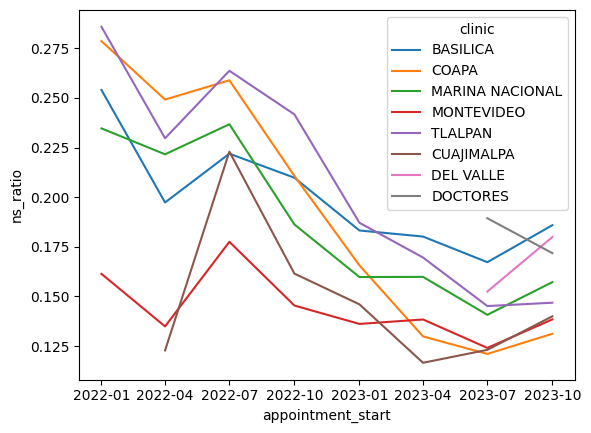

In [139]:
sns.lineplot(
    x="appointment_start", 
    y="ns_ratio",
    hue="clinic",
    data=dfy,
    markers=True
)

---
### No show rate per month

##### Overall

In [8]:
## Params
path = '../../pkg_dir/data/pickles/robs'
name = 'dataset.pkl'


## Reading extract object saved as pickle locally
pkl_obj = path + "/" + name

with open(pkl_obj, 'rb') as obj_content:
    dfx = pickle.load(obj_content)

In [10]:
mr1 = dfx['appointment_status_simplified'].isin(
    [
        'unused', 
        'completed', 
        'no_show', 
    ]
)
# mr2 = dfx['appointment_date'].dt.weekday < 5 ## only weekdays
mrs = mr1 #& mr2

rc = [
    'appointment_id',
    'appointment_start',
    'appointment_status_simplified',
]


dfy = dfx.loc[mrs, rc].copy()

In [11]:
dfy = dfy.groupby(
    [
        pd.Grouper(key='appointment_start', freq='m'),
        'appointment_status_simplified',
    ],
    as_index=False
).agg(
    {
        'appointment_id': 'count',
    }
)

In [13]:
dfy = dfy.pivot(
    index=['appointment_start'], 
    columns=['appointment_status_simplified'], 
    values=['appointment_id'], 
).reset_index()

dfy.columns = [
    col[1] 
    if col[0] == 'appointment_id'
    else col[0]
    for col in dfy.columns
]

In [15]:
dfy['total'] = dfy['completed'] + dfy['no_show'] + dfy['unused']
dfy['total_used'] = dfy['completed'] + dfy['no_show']

In [16]:
dfy['ns_ratio'] = dfy['no_show']/dfy['total_used']

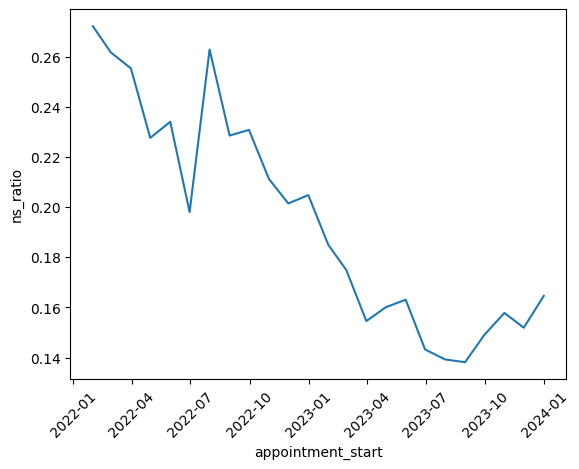

In [19]:
plt = sns.lineplot(
    dfy, 
    x="appointment_start", 
    y="ns_ratio", 
    )

for item in plt.get_xticklabels():
    item.set_rotation(45)

##### Overall

In [29]:
## Params
path = '../../pkg_dir/data/pickles/robs'
name = 'dataset.pkl'


## Reading extract object saved as pickle locally
pkl_obj = path + "/" + name

with open(pkl_obj, 'rb') as obj_content:
    dfx = pickle.load(obj_content)

In [30]:
specialty = ['DERMATOLOGIA', 'GINECOLOGIA', 'OTORRINOLARINGOLOGIA', 'UROLOGIA', 'GASTROENTEROLOGIA', 'ENDOCRINOLOGIA']

In [31]:
mr1 = dfx['appointment_status_simplified'].isin(
    [
        'unused', 
        'completed', 
        'no_show', 
    ]
)
mr2 = dfx['medical_specialty'].isin(specialty)
mrs = mr1 & mr2

rc = [
    'appointment_id',
    'medical_specialty',
    'appointment_start',
    'appointment_status_simplified',
]


dfy = dfx.loc[mrs, rc].copy()

In [32]:
dfy = dfy.groupby(
    [
        pd.Grouper(key='appointment_start', freq='m'),
        'medical_specialty',
        'appointment_status_simplified',
    ],
    as_index=False
).agg(
    {
        'appointment_id': 'count',
    }
)

In [33]:
dfy = dfy.pivot(
    index=['appointment_start', 'medical_specialty'], 
    columns=['appointment_status_simplified'], 
    values=['appointment_id'], 
).reset_index()

dfy.columns = [
    col[1] 
    if col[0] == 'appointment_id'
    else col[0]
    for col in dfy.columns
]

In [35]:
dfy['total'] = dfy['completed'] + dfy['no_show'] + dfy['unused']
dfy['total_used'] = dfy['completed'] + dfy['no_show']

In [36]:
dfy['ns_ratio'] = dfy['no_show']/dfy['total_used']

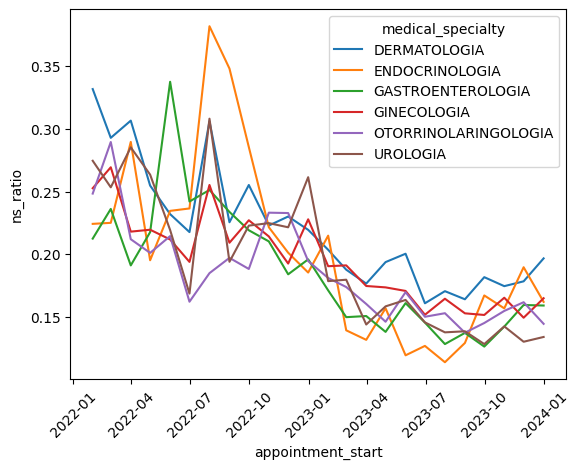

In [39]:
plt = sns.lineplot(
    dfy, 
    x="appointment_start", 
    y="ns_ratio", 
    hue="medical_specialty", 
    )

for item in plt.get_xticklabels():
    item.set_rotation(45)

---
### How many historic data points we have of appointments?

In [ ]:
sql_string = """
SELECT DATE_PART('year', citafecha) as appointment_year,
       COUNT(*) as entry_count

FROM cita

INNER JOIN sucursal ON cita.citasucursalid = sucursal.sucursalid
INNER JOIN citaestatus c ON cita.citaid = c.citaid AND cita.citaanio = c.citaanio

WHERE citafecha >= '2000-11-03'
  AND citafecha < '2024-01-01'
  AND c.cestatusobs ~* '\yCreado\y'
  AND citaestado IN (
                         'DISPONIBLE',
                         'NO_PRESENTO',
                         'COMPLETADA'
                        )

GROUP BY appointment_year

;"""

In [ ]:
dfx = sql_string_to_df(db_crds, sql_string)

dfx.rename(
    columns={
        0: "year",
        1: "count",
    }, 
    inplace=True
)

In [ ]:
dfx

---
### Average number of appointments per speciality

In [140]:
## Params
path = '../../pkg_dir/data/pickles/robs'
name = 'dataset.pkl'


## Reading extract object saved as pickle locally
pkl_obj = path + "/" + name

with open(pkl_obj, 'rb') as obj_content:
    dfx = pickle.load(obj_content)

In [141]:
mr1 = dfx['appointment_status_simplified'].isin(
    [
        'unused', 
        'completed', 
        'no_show', 
    ]
)
mr2 = dfx['appointment_start'].dt.year == 2023
mr3 = dfx['appointment_start'].dt.weekday < 5 ## only weekdays
# mr4 = dfx['clinic'] == 'BASILICA'
mrs = mr1 & mr2 & mr3# & mr4

rc = [
    'appointment_id',
    'appointment_start',
    'clinic',
    'doctor',
    'medical_specialty',
    'appointment_status_simplified',
]

In [142]:
dfy = dfx.loc[mrs, rc].copy()

In [143]:
dfy = dfy.groupby(
    [
        pd.Grouper(key='appointment_start', freq='d'),
        'medical_specialty',
        'appointment_status_simplified',
    ],
    as_index=False
).agg(
    {
        'appointment_id': 'count',
    }
)

dfy

,appointment_start,medical_specialty,appointment_status_simplified,appointment_id
0,2023-01-02,CARDIOLOGIA,completed,10
1,2023-01-02,CARDIOLOGIA,no_show,4
2,2023-01-02,CARDIOLOGIA,unused,4
3,2023-01-02,DERMATOLOGIA,completed,35
4,2023-01-02,DERMATOLOGIA,no_show,13
...,...,...,...,...
14048,2023-12-29,UROLOGIA,no_show,4
14049,2023-12-29,UROLOGIA,unused,24
14050,2023-12-29,Ultrasonido,completed,12
14051,2023-12-29,Ultrasonido,no_show,1


In [144]:
dfy = dfy.pivot(
    index=['appointment_start', 'medical_specialty'], 
    columns=['appointment_status_simplified'], 
    values=['appointment_id'], 
).reset_index()

dfy.columns = [
    col[1] 
    if col[0] == 'appointment_id'
    else col[0]
    for col in dfy.columns
]

In [145]:
## 
dfy.fillna(0, inplace=True)

In [146]:
dfy['total_agenda'] = dfy['completed'] + dfy['no_show'] + dfy['unused']
dfy['total_used'] = dfy['completed'] + dfy['no_show']

dfy['ns_ratio'] = dfy['no_show']/dfy['total_used']
dfy['occupation_ratio'] = 1 - dfy['unused']/dfy['total_agenda']

In [147]:
dfy2 = dfy.groupby(
    [
        'medical_specialty',
    ]
).agg(
    {
        'completed': 'mean',
        'no_show': 'mean',
        'ns_ratio': 'mean',
        'occupation_ratio': 'mean',
        'unused': 'mean',
        # 'total_agenda': ['mean', 'sum'],
        'total_used': ['mean', 'sum'],
        'appointment_start': 'nunique',
    }
)

# dfy2.columns = [col[0] + '_$' + col[1] for col in dfy2.columns]

dfy2.sort_values(by=('total_used', 'sum'), inplace=True, ascending=False)

dfy2

completed    no_show  ns_ratio occupation_ratio  \
                           mean       mean      mean             mean   
medical_specialty                                                       
DERMATOLOGIA          90.107692  19.834615  0.185172         0.900197   
GINECOLOGIA           72.517375  14.270270  0.165426         0.751116   
OTORRINOLARINGOLOGIA  47.243243   8.752896  0.158166         0.829395   
GASTROENTEROLOGIA     39.073359   6.648649  0.148902         0.758984   
UROLOGIA              37.320463   6.339768  0.144285         0.724460   
ENDOCRINOLOGIA        33.258687   5.810811  0.152971         0.828452   
NEUROLOGIA            22.694981   3.610039  0.137280         0.757318   
ULTRASONIDO           22.152344   3.519531  0.144150         0.649702   
CARDIOLOGIA           21.871595   2.824903  0.111722         0.626527   
ORTOPEDIA             20.177606   3.339768  0.145969         0.689755   
REUMATOLOGIA          11.012295   1.610656  0.136011         0.656970   
Ultrasonido            9.606178   1.710425  0.148326         0.563234   
NEUMOLOGIA            10.361702   2.072340  0.185870         0.790696   
PROCTOLOGIA            7.547826   1.695652  0.202054         0.681543   
ANGIOLOGIA            10.358974   2.179487  0.186063         0.877086   
NEFROLOGIA             7.660819   1.228070  0.151016         0.718465   
MEDICINA GENERAL+IA    5.849558   0.694690  0.099687         0.475233   
NUTRICION              4.751073   1.278970  0.237552         0.411492   
MEDICINA INTERNA       5.258929   0.669643  0.106870         0.524088   
PSICOLOGIA             3.212245   0.416327  0.110195         0.388413   
ALERGOLOGIA            7.695122   1.402439  0.140336         0.621028   
PEDIATRIA              2.922414   0.672414  0.183749         0.376450   
OFTALMOLOGIA           1.088496   0.584071  0.528919         0.056622   
ONCOLOGIA              1.523810   0.539683  0.306685         0.179010   
GERIATRIA              3.307692   0.769231  0.173993         0.513736   

                         unused  total_used          appointment_start  
                           mean        mean      sum           nunique  
medical_specialty                                                       
DERMATOLOGIA          12.607692  109.942308  28585.0               260  
GINECOLOGIA           29.440154   86.787645  22478.0               259  
OTORRINOLARINGOLOGIA  11.853282   55.996139  14503.0               259  
GASTROENTEROLOGIA     15.552124   45.722008  11842.0               259  
UROLOGIA              18.270270   43.660232  11308.0               259  
ENDOCRINOLOGIA         8.544402   39.069498  10119.0               259  
NEUROLOGIA             8.918919   26.305019   6813.0               259  
ULTRASONIDO           14.179688   25.671875   6572.0               256  
CARDIOLOGIA           14.918288   24.696498   6347.0               257  
ORTOPEDIA             11.135135   23.517375   6091.0               259  
REUMATOLOGIA           7.131148   12.622951   3080.0               244  
Ultrasonido            8.826255   11.316602   2931.0               259  
NEUMOLOGIA             3.468085   12.434043   2922.0               235  
PROCTOLOGIA            4.365217    9.243478   2126.0               230  
ANGIOLOGIA             1.833333   12.538462   1956.0               156  
NEFROLOGIA             4.228070    8.888889   1520.0               171  
MEDICINA GENERAL+IA    7.314159    6.544248   1479.0               226  
NUTRICION              8.317597    6.030043   1405.0               233  
MEDICINA INTERNA       5.535714    5.928571   1328.0               224  
PSICOLOGIA             5.800000    3.628571    889.0               245  
ALERGOLOGIA            5.804878    9.097561    746.0                82  
PEDIATRIA              6.715517    3.594828    417.0               116  
OFTALMOLOGIA          27.911504    1.672566    189.0               113  
ONCOLOGIA             10.857143    2.063492    130.0                63  
GERIAT

---
### Average number of doctors per specialty and per location

In [ ]:
## Params
path = '../../pkg_dir/data/pickles/robs'
name = 'dataset.pkl'


## Reading extract object saved as pickle locally
pkl_obj = path + "/" + name

with open(pkl_obj, 'rb') as obj_content:
    dfx = pickle.load(obj_content)

In [ ]:
specialty = ['DERMATOLOGIA', 'GINECOLOGIA', 'OTORRINOLARINGOLOGIA', 'UROLOGIA', 'GASTROENTEROLOGIA', 'ENDOCRINOLOGIA']
clinic = ['BASILICA', 'COAPA', 'MARINA NACIONAL', 'TLALPAN', 'MONTEVIDEO']

In [ ]:
mr1 = dfx['appointment_start'].dt.weekday < 5 ## only weekdays
mr2 = dfx['medical_specialty'].isin(specialty)
mr3 = dfx['clinic'].isin(clinic)
mrs = mr1 & mr2 & mr3

rc = [
    'appointment_id',
    'appointment_start',
    'clinic',
        'medical_specialty',
    'doctor',
]

In [ ]:
dfy = dfx.loc[mrs, rc].copy()

In [ ]:
dfy = dfy.groupby(
    [
        pd.Grouper(key='appointment_start', freq='d'),
        'medical_specialty',
        'clinic',
    ],
    as_index=False
).agg(
    {
        'doctor': 'nunique',
    }
)


In [ ]:
dfy = dfy.groupby(
    [
        'medical_specialty',
        'clinic',
    ],
    as_index=False
).agg(
    {
        'doctor': 'mean',
    }
)

dfy

---
### No shows per specialty in 2023

###### 
###### Old calculation

In [ ]:
## Grouping data by clinic
dfy = dfx.groupby(
    [
        'medical_specialty',
        'appointment_status_simple',
    ],
    as_index=False
).agg(
    {
        'appointment_id': 'count'
    }
)

## Renaming aggregate column
dfy.rename(columns={'appointment_id': 'count'}, inplace=True)

In [ ]:
## Adding new column with proportions
dfy["proportion"] = dfy['count']/dfy.groupby(["medical_specialty"])["count"].transform("sum")

In [ ]:
dfy.loc[dfy['appointment_status_simple'] == 'no_show', :].sort_values(by='proportion', ascending=False)

In [ ]:
dfy

In [ ]:
dfy

---
### How many of the no-shows are patients that were confirmed?

In [ ]:
mr1 = dfy['appointment_status_simplified'] == 'no_show'
mrs = mr1

rc = [
    'appointment_id',
    'appointment_date',
    'meta__confirmed_$date',
]

In [ ]:
dfy = dfx.loc[mrs, rc].copy()

In [ ]:
dfy['meta__confirmed_$date'] = dfy['meta__confirmed_$date'].fillna('not_confirmed')

In [ ]:
dfy['meta__confirmed_$date'] = dfy['meta__confirmed_$date'].apply(lambda x: 'confirmed' if x != 'not_confirmed' else x)

In [ ]:
dfy = dfy.groupby(
    [
        pd.Grouper(key='appointment_date', freq='Y'),
        'meta__confirmed_$date',
    ]
).agg(
    'count'
)

dfy

In [ ]:
## Adding new column with proportions per clinic
dfy["proportion"] = dfy['appointment_id']/dfy.groupby(['appointment_date'])["appointment_id"].transform("sum")

In [ ]:
dfy

---
### Appointments by channel

In [ ]:
mr1 = dfx['meta__created_$user'].notnull()
mrs = mr1

rc = [
    'appointment_id',
    'appointment_date',
    'meta__created_$user',
    'appointment_status_simplified',
]

In [ ]:
dfy = dfx.loc[mrs, rc].copy()

In [ ]:
dfy['meta__created_$user'] = dfy['meta__created_$user'].apply(lambda x: 'online' if x == 'citas.online' else 'phone')

In [ ]:
dfy['meta__created_$user'].value_counts()

In [ ]:
dfy[dfy['meta__created_$user'].str.contains('online')]

In [ ]:
dfy['meta__created_$user'].unique()

In [ ]:
dfy[dfy['meta__created_$user'].str.contains('online')]['appointment_status_simplified'].value_counts()

In [ ]:
dfy['meta__created_$user'].info()

In [ ]:
dfx

---
### Specialties and lead time

In [ ]:
## Params
path = '../../pkg_dir/data/pickles/robs'
name = 'dataset.pkl'


## Reading extract object saved as pickle locally
pkl_obj = path + "/" + name

with open(pkl_obj, 'rb') as obj_content:
    dfx = pickle.load(obj_content)

In [ ]:
specialty = ['DERMATOLOGIA', 'GINECOLOGIA', 'OTORRINOLARINGOLOGIA', 'UROLOGIA', 'GASTROENTEROLOGIA', 'ENDOCRINOLOGIA']
appt_status = ['cancel_patient', 'completed', 'no_show']

In [ ]:
dfx['appointment_status_simplified'].unique()

In [ ]:
mr1 = (dfx['creation_to_start_hrs'] > 0) & (dfx['creation_to_start_hrs'] < 12000)
mr2 = dfx['medical_specialty'].isin(specialty)
mr3 = dfx['appointment_status_simplified'].isin(appt_status)

mrs = mr1 & mr2 & mr3

rc = [
    'appointment_id',
    'medical_specialty',
    'creation_to_start_hrs',
    'appointment_status_simplified',
]


dfy = dfx.loc[mrs, rc].copy()

In [ ]:
sns.boxplot(data=dfy, x="creation_to_start_hrs", y="medical_specialty")

In [ ]:
mr1 = (dfx['creation_to_start_hrs'] > 0) & (dfx['creation_to_start_hrs'] < 12000)
mr2 = dfx['medical_specialty'].isin(specialty)
mr3 = dfx['appointment_status_simplified'].isin(appt_status)

mrs = mr1 & mr2 & mr3

rc = [
    'appointment_id',
    'medical_specialty',
    'creation_to_start_hrs',
    'appointment_status_simplified',
]


dfy = dfx.loc[mrs, rc].copy()

In [ ]:
sns.boxplot(data=dfy, x="creation_to_start_hrs", y="medical_specialty", hue='appointment_status_simplified')

---
### How do appointments behave per time of day?

##### 
##### All appointments

In [ ]:
mr1 = dfx['appointment_status_simplified'].isin(
    [
        'unused', 
        'completed', 
        'no_show', 
    ]
)
mr2 = dfx['appointment_date'].dt.weekday < 5 ## only weekdays
mr3 = dfx['appointment_date'].dt.year == 2023 
mrs = mr1 & mr2 & mr3

rc = [
    'appointment_id',
    'appointment_date',
    'appointment_start_time',
    'appointment_status_simplified',
]


dfy = dfx.loc[mrs, rc].copy()

In [ ]:
dfy['start_time'] = dfy['appointment_start_time'].str[:2].astype('float') + dfy['appointment_start_time'].str[-2:].astype('float')/60

In [ ]:
tr = 0.5
bins = np.arange(0, 24 + tr, tr)
dfy['st_bins'] = pd.cut(dfy['start_time'], bins)

In [ ]:
dfy.groupby(
    [
        # 'start_time',
        'st_bins',
    ],
    as_index=False
).agg(
    {
        'appointment_id': 'count',
    }
)

In [ ]:
sns.histplot(
    data=dfy, 
    x="start_time",
    bins=bins,
)

##### 
##### Separating by status

In [ ]:
mr1 = dfx['appointment_status_simplified'].isin(
    [
        'unused', 
        'completed', 
        'no_show', 
    ]
)
mr2 = dfx['appointment_date'].dt.weekday < 5 ## only weekdays
mr3 = dfx['appointment_date'].dt.year == 2023 ## only weekdays
mrs = mr1 & mr2 & mr3

rc = [
    'appointment_id',
    'appointment_date',
    'appointment_start_time',
    'appointment_status_simplified',
]


dfy = dfx.loc[mrs, rc].copy()

In [ ]:
dfy['start_time'] = dfy['appointment_start_time'].str[:2].astype('float') + dfy['appointment_start_time'].str[-2:].astype('float')/60

In [ ]:
tr = 0.5
bins = np.arange(0, 24 + tr, tr)
dfy['st_bins'] = pd.cut(dfy['start_time'], bins)

In [ ]:
dfy.groupby(
    [
        'appointment_status_simplified',
        'st_bins',
    ],
    # as_index=False
).agg(
    {
        'appointment_id': 'count',
    }
)

In [ ]:
sns.histplot(
    data=dfy, 
    x="start_time",
    bins=bins,
    hue='appointment_status_simplified',
)

##### 
##### Focusing on clinic

In [ ]:
mr1 = dfx['appointment_status_simplified'].isin(
    [
        'unused', 
        'completed', 
        'no_show', 
    ]
)
mr2 = dfx['appointment_date'].dt.weekday < 5 ## only weekdays
mr3 = dfx['appointment_date'].dt.year == 2023 ## only weekdays
mr4 = dfx['clinic'] == 'BASILICA' 
mrs = mr1 & mr2 & mr3 & mr4

rc = [
    'appointment_id',
    'appointment_date',
    'appointment_start_time',
    'appointment_status_simplified',
]


dfy = dfx.loc[mrs, rc].copy()

In [ ]:
dfy['start_time'] = dfy['appointment_start_time'].str[:2].astype('float') + dfy['appointment_start_time'].str[-2:].astype('float')/60

In [ ]:
tr = 1
bins = np.arange(0, 24 + tr, tr)
dfy['st_bins'] = pd.cut(dfy['start_time'], bins)

In [ ]:
dfy.groupby(
    [
        'st_bins',
    ],
    as_index=False
).agg(
    {
        'appointment_id': 'count',
    }
)

In [ ]:
sns.histplot(
    data=dfy, 
    x="start_time",
    bins=bins,
)

In [ ]:
sns.histplot(
    data=dfy, 
    x="start_time",
    bins=bins,
    hue='appointment_status_simplified',
    # title='Clinic: Basilica',
)

##### 
##### Focusing on clinic and specialty
- `Any specialty` in `Any clinic`

In [ ]:
## Params
path = '../../pkg_dir/data/pickles/robs'
name = 'dataset.pkl'


## Reading extract object saved as pickle locally
pkl_obj = path + "/" + name

with open(pkl_obj, 'rb') as obj_content:
    dfx = pickle.load(obj_content)

In [ ]:
dfx['appointment_start_hr'] = dfx['appointment_start'].dt.hour

In [ ]:
# specialty = 'DERMATOLOGIA'
# specialty = 'GINECOLOGIA'
# specialty = 'OTORRINOLARINGOLOGIA'
specialty = 'UROLOGIA'

In [ ]:
specialty = ['DERMATOLOGIA', 'GINECOLOGIA', 'OTORRINOLARINGOLOGIA', 'UROLOGIA', 'GASTROENTEROLOGIA', 'ENDOCRINOLOGIA']

In [ ]:
mr1 = dfx['appointment_status_simplified'].isin(
    [
        'no_show', 
        'completed', 
        'unused', 
    ]
)
# mr2 = dfx['appointment_date'].dt.weekday < 5 ## only weekdays
# mr3 = dfx['appointment_date'].dt.year == 2023 ## only weekdays
# mr4 = dfx['clinic'] == 'BASILICA' 
# mr5 = dfx['medical_specialty'] == specialty
mr5 = dfx['medical_specialty'].isin(specialty)

# mrs = mr1 & mr2 & mr3 & mr4 & mr5
# mrs = mr1 & mr2 & mr4 & mr5
# mrs = mr1 & mr4 & mr5
mrs = mr1 & mr5

rc = [
    'appointment_id',
    'appointment_start',
    'appointment_start_hr',
    'appointment_status_simplified',
]


dfy = dfx.loc[mrs, rc].copy()

In [ ]:
dfy = dfy.groupby(
    [
        'appointment_start_hr',
        'appointment_status_simplified',
    ],
    as_index=False
).agg(
    {
        'appointment_id': 'count',
    }
)

# dfy

In [ ]:
dfy = dfy.pivot(
    index=['appointment_start_hr'], 
    columns=['appointment_status_simplified'], 
    values=['appointment_id'], 
).reset_index()

dfy.columns = [
    col[1] 
    if col[0] == 'appointment_id'
    else col[0]
    for col in dfy.columns
]

dfy.fillna(0, inplace=True)

In [ ]:
dfy['total'] = dfy['completed'] + dfy['no_show'] + dfy['unused']
dfy['total_used'] = dfy['completed'] + dfy['no_show']

dfy['ns_ratio'] = dfy['no_show']/dfy['total_used']

In [ ]:
mr1 = dfy['ns_ratio'].notnull()
mr2 = dfy['total_used'] > 100
mrs = mr1 & mr2

dfy = dfy.loc[mrs, :].copy()

In [ ]:
sns.barplot(
    data=dfy, 
    x="appointment_start_hr",
    y="ns_ratio",
)

##### 
##### Focusing on clinic and specialty
- `Gynecology` in Basilica

In [ ]:
## Params
path = '../../pkg_dir/data/pickles/robs'
name = 'dataset.pkl'


## Reading extract object saved as pickle locally
pkl_obj = path + "/" + name

with open(pkl_obj, 'rb') as obj_content:
    dfx = pickle.load(obj_content)

In [ ]:
dfx['appointment_start_hr'] = dfx['appointment_start'].dt.hour

In [ ]:
mr1 = dfx['appointment_status_simplified'].isin(
    [
        'no_show', 
        'completed', 
        'unused', 
    ]
)
# mr2 = dfx['appointment_date'].dt.weekday < 5 ## only weekdays
# mr3 = dfx['appointment_date'].dt.year == 2023 ## only weekdays
mr4 = dfx['clinic'] == 'BASILICA' 
mr5 = dfx['medical_specialty'] == 'GINECOLOGIA'

# mrs = mr1 & mr2 & mr3 & mr4 & mr5
# mrs = mr1 & mr2 & mr4 & mr5
mrs = mr1 & mr4 & mr5

rc = [
    'appointment_id',
    'appointment_start',
    'appointment_start_hr',
    'appointment_status_simplified',
]


dfy = dfx.loc[mrs, rc].copy()

In [ ]:
dfy = dfy.groupby(
    [
        'appointment_start_hr',
        'appointment_status_simplified',
    ],
    as_index=False
).agg(
    {
        'appointment_id': 'count',
    }
)

dfy

In [ ]:
dfy = dfy.pivot(
    index=['appointment_start_hr'], 
    columns=['appointment_status_simplified'], 
    values=['appointment_id'], 
).reset_index()

dfy.columns = [
    col[1] 
    if col[0] == 'appointment_id'
    else col[0]
    for col in dfy.columns
]

dfy.fillna(0, inplace=True)

In [ ]:
dfy['total'] = dfy['completed'] + dfy['no_show'] + dfy['unused']
dfy['total_used'] = dfy['completed'] + dfy['no_show']

dfy['ns_ratio'] = dfy['no_show']/dfy['total_used']

In [ ]:
sns.barplot(
    data=dfy, 
    x="appointment_start_hr",
    y="ns_ratio",
)

---
### How do appointments behave per weekday?

In [ ]:
## Params
path = '../../pkg_dir/data/pickles/robs'
name = 'dataset.pkl'


## Reading extract object saved as pickle locally
pkl_obj = path + "/" + name

with open(pkl_obj, 'rb') as obj_content:
    dfx = pickle.load(obj_content)

In [ ]:
# specialty = 'DERMATOLOGIA'#, 'GINECOLOGIA', 'OTORRINOLARINGOLOGIA', 'UROLOGIA', 'GASTROENTEROLOGIA', 'ENDOCRINOLOGIA']
specialty = 'GINECOLOGIA'#, 'OTORRINOLARINGOLOGIA', 'UROLOGIA', 'GASTROENTEROLOGIA', 'ENDOCRINOLOGIA']
# specialty = ['DERMATOLOGIA', 'GINECOLOGIA', 'OTORRINOLARINGOLOGIA', 'UROLOGIA', 'GASTROENTEROLOGIA', 'ENDOCRINOLOGIA']

In [ ]:
mr1 = dfx['appointment_status_simplified'].isin(
    [
        'unused', 
        'completed', 
        'no_show', 
    ]
)
# mr2 = dfx['appointment_start'].dt.year == 2023 ## only weekdays
# mr2 = dfx['medical_specialty'].isin(specialty)
mr2 = dfx['medical_specialty'] == specialty
mrs = mr1 & mr2

rc = [
    'appointment_id',
    'appointment_weekday',
    'appointment_status_simplified',
]


dfy = dfx.loc[mrs, rc].copy()

In [ ]:
dfy = dfy.groupby(
    [
        'appointment_weekday',
        'appointment_status_simplified',
    ],
    as_index=False
).agg(
    {
        'appointment_id': 'count',
    }
)

In [ ]:
dfy = dfy.pivot(
    index=['appointment_weekday'], 
    columns=['appointment_status_simplified'], 
    values=['appointment_id'], 
).reset_index()

dfy.columns = [
    col[1] 
    if col[0] == 'appointment_id'
    else col[0]
    for col in dfy.columns
]

In [ ]:
dfy['total_agenda'] = dfy['completed'] + dfy['no_show'] + dfy['unused']
dfy['total_used'] = dfy['completed'] + dfy['no_show']

dfy['ns_ratio'] = dfy['no_show']/dfy['total_used']
dfy['occupation_ratio'] = 1 - dfy['unused']/dfy['total_agenda']

In [ ]:
sns.barplot(
    data=dfy, 
    x="appointment_weekday",
    y="ns_ratio",
)

---
### What are the most popular times of day when appointments are scheduled

---
### With how much time in advance are appointments confirmed?

In [ ]:
## Params
path = '../../pkg_dir/data/pickles/robs'
name = 'dataset.pkl'


## Reading extract object saved as pickle locally
pkl_obj = path + "/" + name

with open(pkl_obj, 'rb') as obj_content:
    dfx = pickle.load(obj_content)

In [ ]:
mr1 = dfx['confirm_to_start_hrs'].notnull()
mr2 = dfx['confirm_to_start_hrs'] <= 24*7
mr3 = dfx['confirm_to_start_hrs'] >= 0
mr4 = dfx['appointment_start'].dt.year == 2023
mrs = mr1 & mr2 & mr3 & mr4

rc = [
    'appointment_id',
    'appointment_start',
    'confirm_to_start_hrs',
    'appointment_status_simplified',
]

In [ ]:
dfy = dfx.loc[mrs, rc].copy()

In [ ]:
dfy['confirm_to_start_hrs'].plot(kind='hist', rwidth=0.8, bins=100)

---
### Confirmation time and cancellations
- When can we neglect cancellations as a label?

In [ ]:
## Params
path = '../../pkg_dir/data/pickles/robs'
name = 'dataset_v1.pkl'


## Reading extract object saved as pickle locally
pkl_obj = path + "/" + name

with open(pkl_obj, 'rb') as obj_content:
    dfx = pickle.load(obj_content)

In [ ]:
mr1 = dfx['confirm_to_start_hrs'].notnull()
mr2 = dfx['confirm_to_start_hrs'] <= 24
mrs = mr1 & mr2

rc = [
    'appointment_id',
    'appointment_start',
    'confirm_to_start_hrs',
    'appointment_status_simplified',
]

In [ ]:
dfy = dfx.loc[mrs, rc].copy()

In [ ]:
dfy['confirm_to_start_hrs'].describe()

In [ ]:
dfy.groupby(
    [
        pd.Grouper(key='appointment_start', freq='Y'),
        'appointment_status_simplified',
    ],
).agg(
    {
        'appointment_id': 'count',
    }
)

---
### What's the outcome of appointments that have a confirmation request message?

---
### Patient recurrance

##### Per speciality

In [ ]:
## Params
path = '../../pkg_dir/data/pickles/robs'
name = 'dataset.pkl'


## Reading extract object saved as pickle locally
pkl_obj = path + "/" + name

with open(pkl_obj, 'rb') as obj_content:
    dfx = pickle.load(obj_content)

In [ ]:
specialty = ['DERMATOLOGIA', 'GINECOLOGIA', 'OTORRINOLARINGOLOGIA', 'UROLOGIA', 'GASTROENTEROLOGIA', 'ENDOCRINOLOGIA']

In [ ]:
mr1 = dfx['recurring_patient'].notnull()
mr2 = dfx['medical_specialty'].isin(specialty)

mrs = mr1 & mr2

rc = [
    'appointment_id',
    'medical_specialty',
    'recurring_patient',
]


dfy = dfx.loc[mrs, rc].copy()

In [ ]:
dfy = dfy.groupby(
    [
        'medical_specialty',
        'recurring_patient',
    ],
    as_index=False
).agg(
    {
        'appointment_id': 'count',
    }
)

dfy['proportion'] = dfy['appointment_id']/dfy.groupby(['medical_specialty'])['appointment_id'].transform('sum')

# dfy

In [ ]:
# Medical specialties and their proportions of first-time and recurrent patients
specialties = ['DERMATOLOGIA', 'GINECOLOGIA', 'OTORRINOLARINGOLOGIA', 'UROLOGIA', 'GASTROENTEROLOGIA', 'ENDOCRINOLOGIA']
first_time_proportions = dfy.loc[dfy['recurring_patient'] == 'first', 'proportion']
recurrent_proportions = dfy.loc[dfy['recurring_patient'] == 'recurrent', 'proportion']

# Positions of each medical specialty
ind = np.arange(len(specialties))

# Width of the bars
width = 0.5

# Plotting the bars
fig, ax = plt.subplots()
bars_first_time = ax.bar(ind, first_time_proportions, width, label='First-time')
bars_recurrent = ax.bar(ind, recurrent_proportions, width, bottom=first_time_proportions, label='Recurrent')

# Adding labels, title, and custom x-axis tick labels, etc.
ax.set_xlabel('Medical Specialty')
ax.set_ylabel('Proportion')
ax.set_title('Proportion of First-time and Recurrent Patients by Medical Specialty')
ax.set_xticks(ind)
ax.set_xticklabels(specialties, rotation=45, ha="right")
ax.legend()

# Adding a legend
ax.legend()

plt.show()


---
### Patient recurrance affects no-shows?

##### V1 - no-shows vs completed

In [ ]:
## Params
path = '../../pkg_dir/data/pickles/robs'
name = 'dataset_v1.pkl'


## Reading extract object saved as pickle locally
pkl_obj = path + "/" + name

with open(pkl_obj, 'rb') as obj_content:
    dfx = pickle.load(obj_content)

In [ ]:
mr1 = dfx['appointment_status_simplified'] != 'cancel'
mrs = mr1

rc = [
    'appointment_id',
    'recurring_patient',
    'appointment_status_simplified',
]

In [ ]:
dfy = dfx.loc[mr1, rc].copy()

In [ ]:
dfy = dfy.groupby(
    [
        # pd.Grouper(key='appointment_start', freq='Y'),
        'recurring_patient',
        'appointment_status_simplified',
    ],
    as_index=False
).agg(
    {
        'appointment_id': 'count',
    }
)

dfy["proportion"] = dfy['appointment_id']/dfy.groupby(['recurring_patient'])["appointment_id"].transform("sum")
dfy

##### V5 - failed vs completed

In [ ]:
## Params
path = '../../pkg_dir/data/pickles/robs'
name = 'dataset_v5.pkl'


## Reading extract object saved as pickle locally
pkl_obj = path + "/" + name

with open(pkl_obj, 'rb') as obj_content:
    dfx = pickle.load(obj_content)

In [ ]:
rc = [
    'appointment_id',
    'recurring_patient',
    'appointment_status_simplified',
]

In [ ]:
dfy = dfx.loc[:, rc].copy()

In [ ]:
dfy = dfy.groupby(
    [
        # pd.Grouper(key='appointment_start', freq='Y'),
        'recurring_patient',
        'appointment_status_simplified',
    ],
    as_index=False
).agg(
    {
        'appointment_id': 'count',
    }
)

dfy["proportion"] = dfy['appointment_id']/dfy.groupby(['recurring_patient'])["appointment_id"].transform("sum")
dfy

---
### Age distribution

##### 
##### Focusing on clinic and specialty
- `Any specialty` in `Any clinic`

In [ ]:
## Params
path = '../../pkg_dir/data/pickles/robs'
name = 'dataset.pkl'


## Reading extract object saved as pickle locally
pkl_obj = path + "/" + name

with open(pkl_obj, 'rb') as obj_content:
    dfx = pickle.load(obj_content)

In [ ]:
specialty = ['DERMATOLOGIA', 'GINECOLOGIA', 'OTORRINOLARINGOLOGIA', 'UROLOGIA', 'GASTROENTEROLOGIA', 'ENDOCRINOLOGIA']

In [ ]:
mr1 = dfx['medical_specialty'].isin(specialty)
mr2 = dfx['patient_age'].notnull()

mrs = mr1 & mr2

rc = [
    'appointment_id',
    'medical_specialty',
    'patient_age',
]


dfy = dfx.loc[mrs, rc].copy()

In [ ]:
sns.boxplot(data=dfy, x="patient_age", y="medical_specialty")

---
### How many of the cancellations by chatbot?

---
### Sex distribution

In [42]:
## Params
path = '../../pkg_dir/data/pickles/robs'
name = 'dataset.pkl'


## Reading extract object saved as pickle locally
pkl_obj = path + "/" + name

with open(pkl_obj, 'rb') as obj_content:
    dfx = pickle.load(obj_content)

In [43]:
specialty = ['DERMATOLOGIA', 'GINECOLOGIA', 'OTORRINOLARINGOLOGIA', 'UROLOGIA', 'GASTROENTEROLOGIA', 'ENDOCRINOLOGIA']

In [44]:
mr1 = dfx['patient_sex'].notnull()
mr2 = dfx['medical_specialty'].isin(specialty)

mrs = mr1 & mr2

rc = [
    'appointment_id',
    'medical_specialty',
    'patient_sex',
]


dfy = dfx.loc[mrs, rc].copy()

In [ ]:
dfy = dfy.groupby(
    [
        'medical_specialty',
        'patient_sex',
    ],
    as_index=False
).agg(
    {
        'appointment_id': 'count',
    }
)

dfy['proportion'] = dfy['appointment_id']/dfy.groupby(['medical_specialty'])['appointment_id'].transform('sum')

# dfy

In [ ]:
# Medical specialties and their proportions of first-time and recurrent patients
# specialties = ['DERMATOLOGIA', 'GINECOLOGIA', 'OTORRINOLARINGOLOGIA', 'UROLOGIA', 'GASTROENTEROLOGIA', 'ENDOCRINOLOGIA']
specialties = dfy['medical_specialty'].unique()
female_prop = dfy.loc[dfy['patient_sex'] == 'F', 'proportion']
male_prop = dfy.loc[dfy['patient_sex'] == 'M', 'proportion']

# Positions of each medical specialty
ind = np.arange(len(specialties))

# Width of the bars
width = 0.5

# Plotting the bars
fig, ax = plt.subplots()
bars_first_time = ax.bar(ind, female_prop, width, label='Female')
bars_recurrent = ax.bar(ind, male_prop, width, bottom=female_prop, label='Male')

# Adding labels, title, and custom x-axis tick labels, etc.
ax.set_xlabel('Medical Specialty')
ax.set_ylabel('Proportion')
ax.set_title('Sex ditribution')
ax.set_xticks(ind)
ax.set_xticklabels(specialties, rotation=45, ha="right")
ax.legend()

# Adding a legend
ax.legend()

plt.show()


---
### Distribution of no shows throughout the day

##### Dermatology

In [148]:
## Params
path = '../../pkg_dir/data/pickles/robs'
name = 'dataset.pkl'


## Reading extract object saved as pickle locally
pkl_obj = path + "/" + name

with open(pkl_obj, 'rb') as obj_content:
    dfx = pickle.load(obj_content)

In [149]:
dfx['appointment_start_hr'] = dfx['appointment_start'].dt.hour
# dfx['appointment_start_day'] = dfx['appointment_start'].dt.date

In [150]:
mr1 = dfx['medical_specialty'] == 'DERMATOLOGIA'
mr2 = dfx['clinic'] == 'BASILICA'
mr3 = dfx['appointment_status_simplified'] == 'no_show'

mrs = mr1 & mr2 & mr3

rc = [
    'appointment_id',
    'appointment_start',
    'appointment_start_hr',
]


dfy = dfx.loc[mrs, rc].copy()

In [153]:
dfy = dfy.groupby(
    [
        pd.Grouper(key='appointment_start', freq='d'),
        'appointment_start_hr',
    ],
    as_index=False
).agg(
    {
        'appointment_id': 'count',
    }
)


In [126]:
dfy = dfy.groupby(
    [
        'appointment_start_hr',
    ],
    as_index=False
).agg(
    {
        'appointment_id': ['mean', 'sum'],
    }
)

dfy

appointment_start_hr appointment_id     
                                  mean  sum
0                     7       1.060606  105
1                     8       1.517060  578
2                     9       1.453258  513
3                    10       1.450276  525
4                    11       1.454545  480
5                    12       1.491279  513
6                    13       1.531328  611
7                    14       1.146552  133
8                    15       1.237668  276
9                    16       1.207547  256
10                   17       1.250000  280
11                   18       1.276995  272
12                   19       1.263889  273

---
### How many days of the year went by with a no-show

In [102]:
## Params
path = '../../pkg_dir/data/pickles/robs'
name = 'dataset.pkl'


## Reading extract object saved as pickle locally
pkl_obj = path + "/" + name

with open(pkl_obj, 'rb') as obj_content:
    dfx = pickle.load(obj_content)

In [103]:
mr1 = dfx['medical_specialty'] == 'DERMATOLOGIA'
mr2 = dfx['clinic'] == 'BASILICA'
mr3 = dfx['appointment_status_simplified'].isin(['completed', 'no_show', 'unused'])

mrs = mr1 & mr2 & mr3

rc = [
    'appointment_id',
    'appointment_start',
    'appointment_status_simplified',
]


dfy = dfx.loc[mrs, rc].copy()

In [104]:
dfy = dfy.groupby(
    [
        pd.Grouper(key='appointment_start', freq='d'),
        'appointment_status_simplified',
    ],
    as_index=False
).agg(
    {
        'appointment_id': 'count',
    }
)


In [105]:
dfy = dfy.pivot(
    index=['appointment_start'], 
    columns=['appointment_status_simplified'], 
    values=['appointment_id'], 
).reset_index()

dfy.columns = [
    col[1] 
    if col[0] == 'appointment_id'
    else col[0]
    for col in dfy.columns
]

dfy.fillna(0, inplace=True)

In [109]:
dfy['total'] = dfy['completed'] + dfy['no_show'] + dfy['unused']
dfy['total_bool'] = dfy['total'].apply(lambda x: 1 if x > 0 else 0)
dfy['no_show_bool'] = dfy['no_show'].apply(lambda x: 1 if x > 0 else 0)

In [111]:
dfy['no_show_bool'].value_counts(normalize=True)

no_show_bool
1    0.990307
0    0.009693
Name: proportion, dtype: float64

In [112]:
dfy.groupby(
    [
        pd.Grouper(key='appointment_start', freq='Y'),
    ],
    as_index=False
).agg(
    {
        'total_bool': 'sum',
        'no_show_bool': 'sum',
    }
)


,appointment_start,total_bool,no_show_bool
0,2022-12-31,304,301
1,2023-12-31,315,312


---
### xxx

---
---
# Solving questions - cancelations

In [ ]:
## Params
path = '../../pkg_dir/data/pickles/robs'
name = 'dataset.pkl'


## Reading extract object saved as pickle locally
pkl_obj = path + "/" + name

with open(pkl_obj, 'rb') as obj_content:
    dfx = pickle.load(obj_content)

---
### What is the cancellation rate
- How many cancellations per employee are there in a day per number of used spots (no-show & completed)

In [ ]:
# mr1 = dfx['appointment_status_simplified'].isin(['unused', 'completed', 'no_show'])
mr1 = dfx['appointment_status_simplified'].isin(['completed', 'no_show'])
mr2 = dfx['appointment_start'].dt.year == 2023
mrs = mr1 & mr2

rc = ['appointment_status_simplified', 'appointment_id']

In [ ]:
dfx.loc[mrs, 'appointment_status_simplified'].value_counts()

In [ ]:
dfx.loc[mrs, 'appointment_status_simplified'].value_counts(normalize=True)

In [ ]:
#2022
31176 / (31176 + 103480)

In [ ]:
#2023
25653 / (25653 + 138654)

In [ ]:
dfx

---
---
# Notes

### Duplicated values

In [ ]:
dfx.loc[dfx[['appointment_id']].duplicated(keep=False), :].sort_values('appointment_id')

### Executing custom query

In [ ]:
sql_string = """
SELECT cita.citaid as appointment_id

FROM cita

WHERE citafecha >= '2000-11-03'
  AND citafecha <= '2021-01-01'

ORDER BY
    citafecha DESC

LIMIT 10

;
"""

In [ ]:
dfx = sql_string_to_df(db_crds, sql_string)

dfx.rename(
    columns={
        0: "appointment_id",
    }, 
    inplace=True
)

### Number of total appointments

In [ ]:
mr1 = dfx['appointment_status_simplified'].isin(
    [
        'completed', 
    ]
)
# mr2 = dfx['appointment_date'].dt.weekday < 5 ## only weekdays
mrs = mr1# & mr2

rc = [
    'appointment_id',
    'appointment_date',
    'clinic',
    'doctor',
    'medical_specialty',
    'appointment_status_simplified',
]

In [ ]:
dfy = dfx.loc[mrs, rc].copy()

In [ ]:
dfy2 = dfy.groupby(
    [
        # pd.Grouper(key='appointment_date', freq='W'),
        'appointment_date',
        'clinic',
    ],
    as_index=False
).agg(
    {
        'doctor': 'nunique'
    }
)

dfy2[-25:]

In [ ]:
dfy2.groupby(
    [
        pd.Grouper(key='appointment_date', freq='Y'),
    ]
).agg(
    {
        'appointment_status_simplified': 'mean'
    }
)

In [ ]:
dfy = dfy.groupby(
    [
        'appointment_date',
        'medical_specialty',
        'appointment_status_simplified',
    ],
    as_index=False
).agg(
    {
        'appointment_id': 'count',
    }
)

dfy

### xxx

---

---